In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
from IPython.display import display
import textwrap
import json 
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

## Import speech dataset and preprocessed data for lda

In [3]:
filename = "data/csv/df_translated.csv"

df = pd.read_csv(filename)
df["year"] = df.apply(lambda s: int(s["date"][:4]), axis=1)
df["uq_agenda"] = df["agenda"]+df["date"]

In [4]:
# import preprocessed data: tokenization, lemmatization, stopword removal
preprocessed_data = json.load(open("data/lda/preprocessed_texts_all_translated.json"))

## Adjust party variable

In [5]:
# remove all speakers without clear political affiliation:

# only use speeches where speaker is associated with a party
df_party_members = df[~(df["party"] == "-")]
# remove non-inscrits: no party group affiliation
# df_party_members = df_party_members[~(df_party_members["party"] == "NI")]
# remove TGI: technical group of independents, no party group affiliation
# df_party_members = df_party_members[~(df_party_members["party"] == "TGI")]

# only keep speeches with at least 50 characters: important for coherence with preprocessed data
df_party_members = df_party_members[df_party_members["translatedText"].map(str).map(len) > 50]
print(len(df_party_members))
assert len(df_party_members) == len(preprocessed_data)

505705


In [6]:
# merge parties that changed names over time
df_party_members['party_adj'] = df_party_members['party']  # start with a copy

df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_adj'] = 'PSE/S&D' # PSE becomes S&D
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_adj'] = 'PPE' # PPE-DE' becomes 'PPE'
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD']), 'party_adj'] = 'EFD' # 'EFDD' becomes 'EFD'
df_party_members.loc[df_party_members['party'].isin(['ITS', 'ENF', 'ID']), 'party_adj'] = 'ENF/ID' # ENF becomes ID in 2019
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_adj'] = 'ELDR/ALDE/Renew' # ELDR becomes ALDE becomes Renew
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_adj'] = 'NGL/The Left' # GUE/NGL becomes The Left
df_party_members.loc[df_party_members['party'].isin(['IND/DEM','EDD']), 'party_adj'] = 'INDDEM/EDD' # independents become EDD

# print information
display(df_party_members["party_adj"].value_counts())

party_adj
PPE                162460
PSE/S&D            119501
NGL/The Left        46465
ELDR/ALDE/Renew     42610
ECR                 29222
Greens/EFA          26260
NI                  26147
EFD                 22172
ENF/ID              20787
UEN                  5171
INDDEM/EDD           4436
TGI                   474
Name: count, dtype: int64

In [7]:
# add column: party block
df_party_members['party_block'] = df_party_members['party']  # start with a copy

# left
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_block'] = 'left'
# green
df_party_members.loc[df_party_members['party'].isin(['Greens/EFA']), 'party_block'] = 'greens'
# social democratic
df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_block'] = 'social_democratic'
# christian conservative
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_block'] = 'christian_conservative'
# liberal
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_block'] = 'liberal'
# right populist
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD','ITS', 'ENF', 'ID', 'IND/DEM', 'ECR', 'UEN', 'EDD']), 'party_block'] = 'right_populist'

# print information
display(df_party_members["party_block"].value_counts())

party_block
christian_conservative    162460
social_democratic         119501
right_populist             81788
left                       46465
liberal                    42610
greens                     26260
NI                         26147
TGI                          474
Name: count, dtype: int64

In [8]:
# save df_party_members to csv
# df_party_members.to_csv("data/csv/speech_output_parties.csv", index=False)

### We still need to translate speeches post 2019: how many? 

In [9]:
# df_untranslated = df_party_members[df_party_members["translatedText"].isna()]
# df_untranslated.head()

# # compute number of speeches to be translated
# num_speeches = df_untranslated.shape[0]
# print(f"Number of speeches to be translated: {num_speeches}")

# # compute number of speeches already translated
# num_speeches_translated = df_party_members.shape[0]
# print(f"Number of speeches already translated: {num_speeches_translated}")

# # compute number of characters in untranslated speeches
# total_chars = df_untranslated["text"].apply(len).sum()
# print(f"Total characters to be translated: {total_chars}")

# total_chars_translated = df_party_members["text"].apply(len).sum()
# print(f"Total characters already translated: {total_chars_translated}")

In [10]:
# # for now: only use speeches which were given in english or machine translation availible
# df_party_members = df_party_members[df_party_members["translatedText"].notna()]

In [11]:
# synchronize preprocessed_data with df_party_members by filtering to matching indices
# create a boolean mask based on the original df indices
# original_indices = df.index.tolist()
# kept_indices_set = set(df_party_members.index.tolist())
# mask = [i in kept_indices_set for i in original_indices]
# preprocessed_data = [preprocessed_data[i] for i, keep in enumerate(mask) if keep]
# print(f"Filtered preprocessed_data to {len(preprocessed_data)} entries")
# print(f"df_party_members has {len(df_party_members)} rows")
# print(f"Lengths match: {len(preprocessed_data) == len(df_party_members)}")

# df_party_members = df_party_members.reset_index(drop=True)

In [12]:
df_party_members = df_party_members.reset_index(drop=True)

## LDA: Define 80 (for now) topics and assign their probabilities to each speech

In [13]:
print("creating dictionary")
dictionary = corpora.Dictionary(preprocessed_data)
print("filtering dictionary")
dictionary.filter_extremes(
    no_below=10,     # Keep tokens appearing in at least 10 docs
    no_above=0.4,    # Remove tokens appearing in more than 40% of docs
    keep_n=100000    # Keep only the top 100k words by frequency
)
corpus = [dictionary.doc2bow(l) for l in tqdm(preprocessed_data, "Preparing corpus")]

creating dictionary
filtering dictionary


Preparing corpus: 100%|██████████| 505705/505705 [00:24<00:00, 20558.78it/s]


In [14]:
def print_topics(model, n_topics, k_words=5):
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx + 1}: {label}")

In [15]:
def assign_topics(lda_model, corpus):
    # choose the LDA model to use (change if you want a different one)
    topics = []
    for bow in tqdm(corpus, desc="Assigning most probable topic to each doc"):
        docs_topics = lda_model.get_document_topics(bow, minimum_probability=0)
        topics.append(docs_topics)
    return topics

## Assign topics to speeches using pre-trained model

In [16]:
n_topics = 80
model = LdaModel.load(f"data/lda/{n_topics}_topics/model.model")

corpus_topics = assign_topics(model, corpus)

Assigning most probable topic to each doc: 100%|██████████| 505705/505705 [02:08<00:00, 3941.05it/s]


In [17]:
# print list of topics
print_topics(model, n_topics)

Topic 1: social, employment, people, poverty, unemployment
Topic 2: tax, country, development, aid, taxation
Topic 3: change, climate, world, need, global
Topic 4: vote, amendment, report, group, text
Topic 5: water, environmental, environment, waste, directive
Topic 6: international, legal, court, state, civil
Topic 7: america, american, united, morocco, latin
Topic 8: health, research, disease, risk, scientific
Topic 9: right, human, fundamental, law, respect
Topic 10: refugee, asylum, country, migration, border
Topic 11: state, member, union, national, area
Topic 12: child, family, roma, school, people
Topic 13: fund, disaster, solidarity, aid, assistance
Topic 14: eu, security, policy, report, foreign
Topic 15: policy, money, agricultural, rural, area
Topic 16: regulation, directive, proposal, commission, report
Topic 17: forest, land, prize, natural, resource
Topic 18: woman, gender, man, equality, violence
Topic 19: emission, climate, target, co, change
Topic 20: crime, criminal,

In [18]:
# corpus topics is a list of lists of (topic_id, probability) tuples for each document in the corpus
# turn this list into dataframe of size (num_docs, num_topics) with probabilities
num_docs = len(corpus_topics)
num_topics = n_topics
topic_prob_matrix = np.zeros((num_docs, num_topics))
for doc_idx, doc_topics in enumerate(corpus_topics):
    for topic_id, prob in doc_topics:
        topic_prob_matrix[doc_idx, topic_id] = prob
topic_prob_df = pd.DataFrame(topic_prob_matrix, columns=[f"topic_{i}" for i in range(num_topics)])
topic_prob_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79
0,0.009112,0.000052,0.000052,0.042362,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,...,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052
1,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.114399,0.000130,...,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.019632,0.000130
2,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,...,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065
3,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,...,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152
4,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,...,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160


In [19]:
# append topic probabilities to df_party_members
df_topics = pd.concat([df_party_members.reset_index(drop=True), topic_prob_df], axis=1)
df_topics.head()

,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79
0,Daniel Freund,"Frau Präsidentin, liebe Kolleginnen und Kolleg...",Greens/EFA,2024-04-25,2. Interinstitutional Body for Ethical Standar...,2,,6403.0,9,False,...,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052
1,Sven Simon,"Madam President, colleagues, this last day of ...",PPE,2024-04-25,2. Interinstitutional Body for Ethical Standar...,4,,6398.0,9,False,...,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.000130,0.019632,0.000130
2,Gabriele Bischoff,"Frau Präsidentin, werte Kommission, Kolleginne...",S&D,2024-04-25,2. Interinstitutional Body for Ethical Standar...,5,,6399.0,9,False,...,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065
3,Gilles Boyer,"Madame la Présidente, Monsieur le Commissaire,...",Renew,2024-04-25,2. Interinstitutional Body for Ethical Standar...,6,,6401.0,9,False,...,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152
4,Heidi Hautala,"Madam President, we really have to thank Danie...",Greens/EFA,2024-04-25,2. Interinstitutional Body for Ethical Standar...,7,,6403.0,9,False,...,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160


In [27]:
# exlude "NI" and "TGI" from party columns, these are non-inscrits without party group affiliation
df_topics = df_topics[~df_topics["party"].isin(["NI", "TGI"])]

## Migration Speeches

In [41]:
# return first 10 words for topic 9 and 39 and their probabilities
for topic_id in [9, 39]:
    topic_terms = model.get_topic_terms(topicid=topic_id, topn=10)
    terms_with_words = [(dictionary[id], prob) for id, prob in topic_terms]
    print(f"Topic {topic_id} terms:")
    for word, prob in terms_with_words:
        print(f"  {word}: {prob:.4f}")


Topic 9 terms:
  refugee: 0.0434
  asylum: 0.0339
  country: 0.0286
  migration: 0.0259
  border: 0.0252
  people: 0.0205
  migrant: 0.0169
  need: 0.0129
  problem: 0.0124
  europe: 0.0118
Topic 39 terms:
  immigration: 0.0461
  illegal: 0.0423
  italy: 0.0365
  ro: 0.0358
  italian: 0.0294
  immigrant: 0.0284
  country: 0.0200
  europe: 0.0189
  mediterranean: 0.0126
  gentleman: 0.0122


### basic interpretation: topic 9 is more neutral refugee, topic 39 is more related to the situation in italy, and more pushed by right-wing populists

In [82]:
# get migration dataset
topic_id_migration_neutral = 9
topic_id_migration_italy = 39
prob_threshold = 0.25
df_migration_neutral = df_topics[df_topics[f"topic_{topic_id_migration_neutral}"] >= prob_threshold]
print(f"Number of speeches in topic migration_neutral (topic {topic_id_migration_neutral} with prob >= {prob_threshold}): {df_migration_neutral.shape[0]}")
df_migration_italy = df_topics[df_topics[f"topic_{topic_id_migration_italy}"] >= prob_threshold]
print(f"Number of speeches in topic migration_italy (topic {topic_id_migration_italy} with prob >= {prob_threshold}): {df_migration_italy.shape[0]}")

Number of speeches in topic migration_neutral (topic 9 with prob >= 0.25): 8221
Number of speeches in topic migration_italy (topic 39 with prob >= 0.25): 1068


### Test: Display migration speeches with lowest probability that is still above threshold

In [83]:
df_migration_sorted_neutral = df_migration_neutral.sort_values(by=f"topic_{topic_id_migration_neutral}")
speech_number = 10
print("Just passing speeches for migration_neutral topic:")
for idx, row in df_migration_sorted_neutral.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_neutral}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Just passing speeches for migration_neutral topic:
Year: 2012, Topic Probability: 0.2501
(RO) We are homing in again on the solidarity aspects of the asylum policy in the wake of recent
events, such as the serious socio-economic crisis in several EU Member States which are hosting
waves of asylum seekers and are in the position of being unable to manage this problem as
efficiently as they would like. All these aspects obviously require major changes to be made to
asylum policy at European Union level. A common approach in this area must be added, and there must
be a consistent show of solidarity on asylum policy among Member States and between them and the
EU’s agencies. Finally, improvements in this regard need to be made as soon as possible and in every
area, but especially in terms of harmonising legislation, both by making better use of budget
resources and by improving the allocation of powers among Member States.

------------------------------------------------------------------

In [84]:
df_migration_sorted_italy = df_migration_italy.sort_values(by=f"topic_{topic_id_migration_italy}")
speech_number = 10
print("Just passing speeches for migration_italy topic:")
for idx, row in df_migration_sorted_italy.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_italy}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Just passing speeches for migration_italy topic:
Year: 2019, Topic Probability: 0.2501
President, colleagues, the Somali-British poet Warsan Shire wrote: “No one puts their children in a
boat unless the water is safer than the land.” It should be clear that in Europe, the water is not
safer than the land. The number of deaths in the Mediterranean in 2018 was no less than five times
higher than in the disaster year 2015. Five times! Why is that, colleagues? Well, because Europe is
on the wrong path. We talk a lot about European values, but we don't act on them. The number of
search and rescue operations at sea has decreased. Certain member states criminalize NGOs for saving
human lives. Those are European values standing on their head, and these are actually practices we
would expect from Trump or Putin. We do not let people drown in Europe. We take our responsibility.
Mr. Commissioner, I would like to ask you: make a reality of a truly European asylum policy.
Intensify the fight agains

### Test: Display speeches with highest probability

In [ ]:
df_migration_sorted_neutral = df_migration_neutral.sort_values(by=f"topic_{topic_id_migration_neutral}", ascending=False)
speech_number = 10
print("Top speeches for migration_neutral topic:")
for idx, row in df_migration_sorted_neutral.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_neutral}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Year: 2016, Topic Probability: 0.9506
Given the current number of asylum seekers in Greece and the increasing number of asylum seekers
arriving in Italy, I believe that there will remain a high demand for emergency relocation places.

----------------------------------------------------------------------------------------------------

Year: 2019, Topic Probability: 0.8832
Mr. President, colleagues, it is necessary to remind that this proposal actually responds to a big
mistake that happened in 2015-2016, when the Schengen border was not protected as it should be.
Almost two million migrants came to Europe between 2015 and 2017. Some were indeed legal refugees
fleeing the violence of war, but there were also a number of ineligible immigrants who should be
returned. That is why I welcome the strengthening of the border and coast guard. The European Union
must protect its security, the European Union must provide asylum to those who really need asylum.
The problem is that if thousands of 

In [50]:
df_migration_sorted_italy = df_migration_italy.sort_values(by=f"topic_{topic_id_migration_italy}", ascending=False)
speech_number = 10
print("Top speeches for migration_italy topic:")
for idx, row in df_migration_sorted_italy.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_italy}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Top speeches for migration_italy topic:
Year: 2014, Topic Probability: 0.7214
A few months ago we were describing the Mediterranean sea as a cemetery because of major disasters
that occurred in it and that left hundreds of victims, including drowned children. Fortunately in
recent months we have not had similar tragedies. I say fortunately because this in no way means that
the problem of illegal immigrants is being overcome. Right up until a few days ago, hundreds, not to
mention thousands, of illegal immigrants ended up in Italy. Every step taken to save the lives of
immigrants should have the support of everyone, but they should also have the necessary support for
those countries for whom the problem of illegal immigration has become a big one.

----------------------------------------------------------------------------------------------------

Year: 2018, Topic Probability: 0.6658
Madam President, ladies and gentlemen, in recent years Italy has been invaded by 700 thousand
illegal 

In [85]:
# save combined migration data to csv
df_migration = pd.concat([df_migration_neutral, df_migration_italy]).drop_duplicates().reset_index(drop=True)
df_migration.to_csv("migration_speeches_lda.csv", sep="\t")

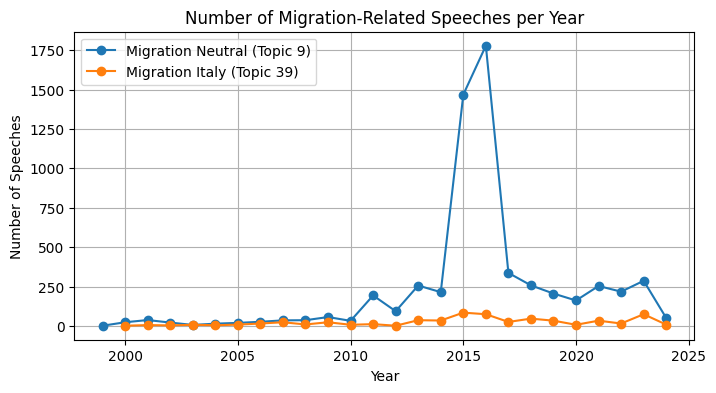

In [54]:
# plot number of speeches in topic 9 and 39 per year
migration_neutral_counts_per_year = df_migration_neutral['year'].value_counts().sort_index()
migration_italy_counts_per_year = df_migration_italy['year'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
plt.plot(migration_neutral_counts_per_year.index, migration_neutral_counts_per_year.values, marker='o', label='Migration Neutral (Topic 9)')
plt.plot(migration_italy_counts_per_year.index, migration_italy_counts_per_year.values, marker='o', label='Migration Italy (Topic 39)')
plt.title('Number of Migration-Related Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend()
plt.grid()
plt.show()

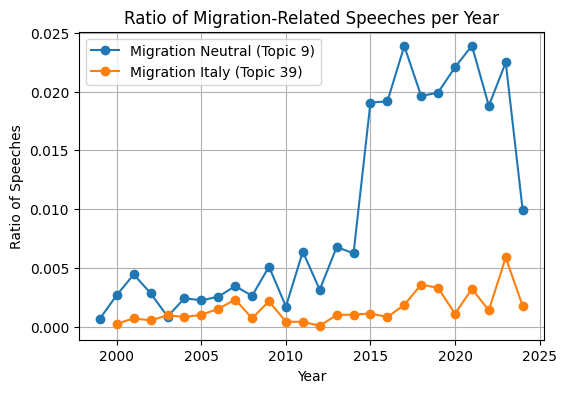

In [58]:
# normalized plot: ratio of migration speeches to total speeches per year
speech_counts_per_year = df_party_members['year'].value_counts().sort_index()
ratio_neutral_per_year = migration_neutral_counts_per_year / speech_counts_per_year
ratio_neutral_per_year = ratio_neutral_per_year.dropna()  # remove NaN values
ratio_italy_per_year = migration_italy_counts_per_year / speech_counts_per_year
ratio_italy_per_year = ratio_italy_per_year.dropna()  # remove NaN values
plt.figure(figsize=(6, 4))
plt.plot(ratio_neutral_per_year.index, ratio_neutral_per_year.values, marker='o', label='Migration Neutral (Topic 9)')
plt.plot(ratio_italy_per_year.index, ratio_italy_per_year.values, marker='o', label='Migration Italy (Topic 39)')
plt.title('Ratio of Migration-Related Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Ratio of Speeches')
plt.legend()
plt.grid()
plt.show()

In [68]:
# create color legend for party blocks
party_block_colors = {
    'left': 'purple',
    'greens': 'green',
    'social_democratic': 'red',
    'christian_conservative': 'black',
    'liberal': 'orange',
    'right_populist': 'blue'
}

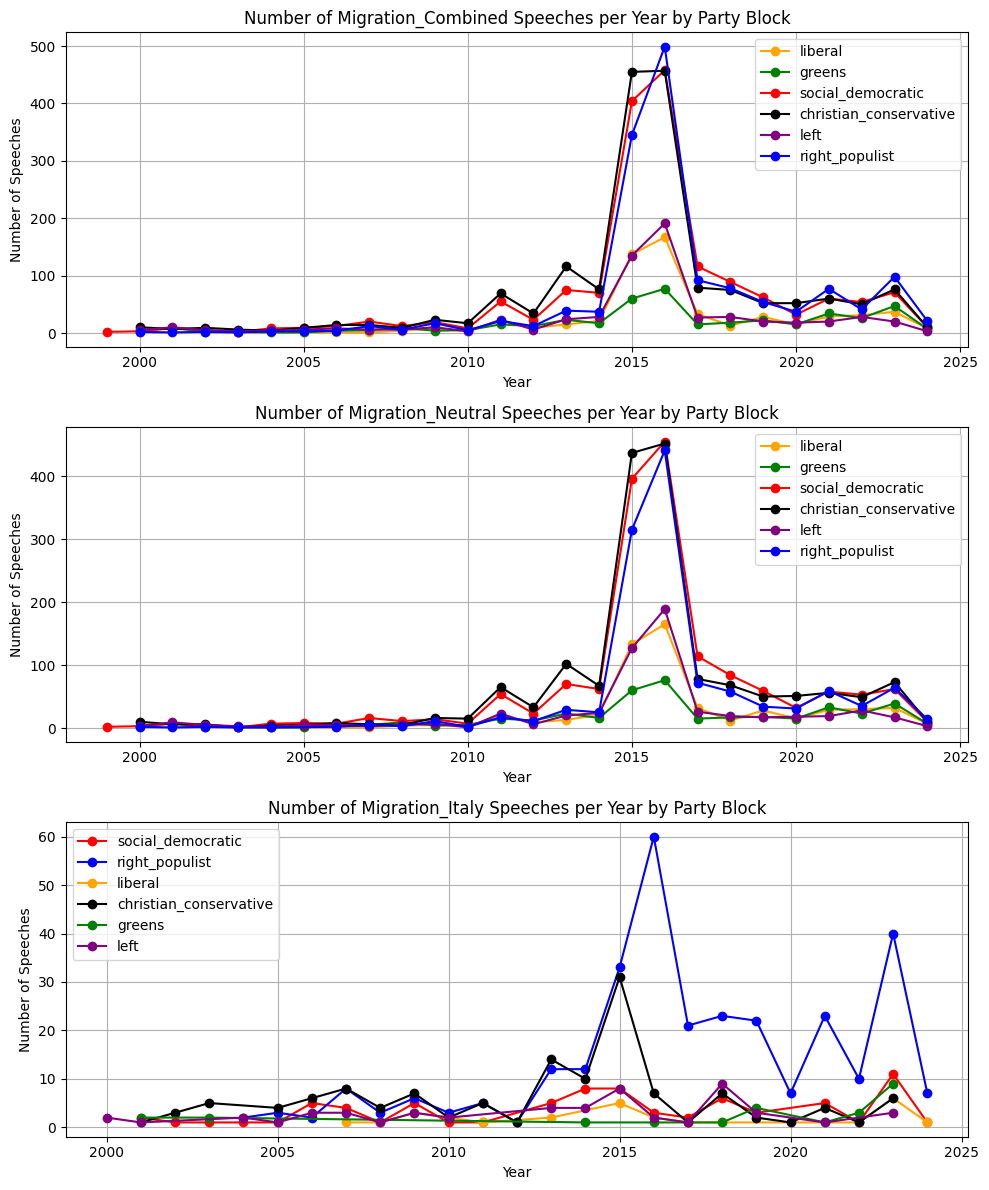

In [77]:
# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Define datasets and titles
datasets = [
    (df_migration, 'Migration_Combined'),
    (df_migration_neutral, 'Migration_Neutral'),
    (df_migration_italy, 'Migration_Italy')
]

# Plot each dataset
for ax, (data, title) in zip(axes, datasets):
    for party_block in data['party_block'].unique():
        party_block_data = data[data['party_block'] == party_block]
        counts_per_year = party_block_data['year'].value_counts().sort_index()
        ax.plot(counts_per_year.index, counts_per_year.values, marker='o', 
                label=party_block, color=party_block_colors.get(party_block))
    
    ax.set_title(f'Number of {title} Speeches per Year by Party Block')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Speeches')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


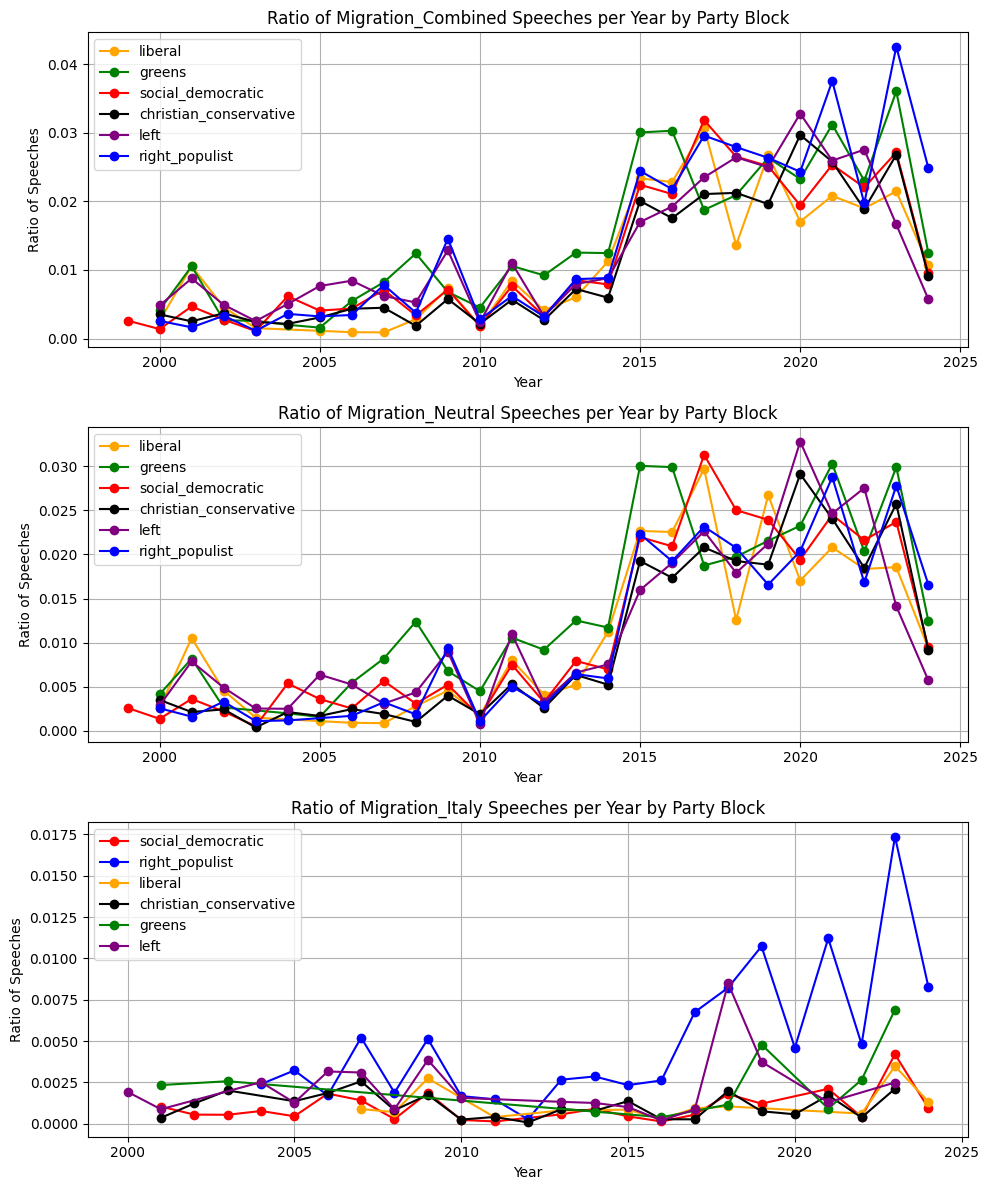

In [78]:
# Create single figure with all three migration datasets
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Define datasets and titles
datasets = [
    (df_migration, 'Migration_Combined'),
    (df_migration_neutral, 'Migration_Neutral'),
    (df_migration_italy, 'Migration_Italy')
]

# Plot each dataset
for ax, (data, title) in zip(axes, datasets):
    for party_block in data['party_block'].unique():
        party_block_data = data[data['party_block'] == party_block]
        counts_per_year = party_block_data['year'].value_counts().sort_index()
        total_counts_per_year = df_party_members[df_party_members['party_block'] == party_block]['year'].value_counts().sort_index()
        ratio_per_year = counts_per_year / total_counts_per_year
        ratio_per_year = ratio_per_year.dropna()
        ax.plot(ratio_per_year.index, ratio_per_year.values, marker='o', 
                label=party_block, color=party_block_colors.get(party_block))
    
    ax.set_title(f'Ratio of {title} Speeches per Year by Party Block')
    ax.set_xlabel('Year')
    ax.set_ylabel('Ratio of Speeches')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


## Old approach: Use Keyword search to find relevant agendas / speeches

In [ ]:
# keywords = ["(M|m)igration", "(M|m)igrant", "(R|r)efugee", "(A|a)sylum", "(T|t)hird(-)?country national"]#, "(F|f)rontex"]
# indices_keyword_identified_speeches = df_party_members.index[df_party_members["uq_agenda"].str.contains("|".join(keywords))].tolist()
# TODO: potentially find relevant keywords using word2vec over text and look for words similar to migration? 

In [ ]:
# def filter_for_keywords(df, column="agenda", keywords=keywords, min_contributions_per_agenda_item=10): 
#     relevant_indices = df[column].str.contains("|".join(keywords))
#     agenda_items_vc = df[relevant_indices]["uq_agenda"].value_counts()
    
#     # TODO: do this filtering in the beginning because why not
#     n_agenda_items_before = len(agenda_items_vc)
#     relevant_agendas = agenda_items_vc[agenda_items_vc > min_contributions_per_agenda_item]
#     n_agenda_items_after = len(relevant_agendas)
#     print(f"filtered {n_agenda_items_before-n_agenda_items_after} agenda items with < {min_contributions_per_agenda_item} speeches")
    
#     relevant_indices = relevant_indices & (df["uq_agenda"].isin(relevant_agendas.index))
    
#     print(f"n speeches: {len(df[relevant_indices])}")
#     print(f"n agendas: {n_agenda_items_after}")
    
#     return df[relevant_indices]

In [ ]:
# # agenda items per year; speech per year; 
# # party per agenda item
# # contribution per party per year
# # normalize by original 
# df_filtered = filter_for_keywords(df)

In [ ]:
# n_per_year_and_party = df_filtered.groupby(["year"]).size()#.unstack()

# ax = n_per_year_and_party.plot(kind="bar", stacked=False, figsize=(40, 5))
# shortened_labels = [l[:50]+"..." if len(l) > 50 else l for l in [lb.get_text() for lb in ax.get_xticklabels()]]
# _ = ax.set_xticklabels(shortened_labels)

In [ ]:
# vc = df_filtered["uq_agenda"].value_counts()
# vc

In [ ]:
# df_filtered_text = filter_for_keywords("text")

In [ ]:
# n = df_filtered_text["uq_agenda"].value_counts()
# print(n.min(), n.mean(), n.max())

# #df_filtered["uq_agenda"]
# print(len(n))
# # agendas that with more than 4 speeches with relevant keywords, that are not in the agendas that were discovered with keywords in title
# new_relevant_agendas = n[(n>4) & (~n.index.isin(df_filtered["uq_agenda"]))]
# new_relevant_agendas[:20]

In [ ]:
# def print_agenda(search_term, n_speeches=None): 
#     all_agendas = df[df["uq_agenda"].str.contains(search_term)]["uq_agenda"].unique()
#     for agenda in all_agendas: 
#         speeches = df[df["uq_agenda"] == agenda].sort_values(by="speechnumber", ascending=True)
#         print("Agenda:", (agenda[:30]+"..." if len(agenda) > 30 else agenda))
#         print("Nr of speeches:", len(speeches))
#         print("")
        
#         if n_speeches:
#             speeches = speeches[:n_speeches]
#         for _, r in speeches.iterrows(): 
#             print(f'({r["speechnumber"]}) {r["speaker"]} ({r['party']}): {r['text'] if not r['translatedText'] else r["translatedText"]}')

In [ ]:
# print_agenda("6.4. Situation of fundamental rights in the European Union in 2015", 10)
# print_agenda("7.7. The situation of women refugees and asylum seekers in the EU", 10)
# print_agenda("European Border and Coast Guard", 10)

## Model evaluation

In [ ]:
# def evaluate_model(lda_model, dictionary, compute_coherence=True): 
#     if compute_coherence: 
#         print("Computing coherence")
#         coherence_model = CoherenceModel(
#             model=lda_model, 
#             texts=preprocessed_data, 
#             dictionary=dictionary, 
#             coherence='c_v'  # most common coherence measure
#         )
#         coherence_score = coherence_model.get_coherence()
#         print("Coherence:", coherence_score)
#     else: 
#         coherence_score = None 
        
#     # compute which topics are related to migration 
#     migration_topic_indices = lda_model.get_term_topics(lda_model.id2word.token2id["migration"], minimum_probability=0)
#     print("Topics related to 'migration':", len(migration_topic_indices))
    
#     # check if any migration-related topic has probability > 0.05 (arbitrary threshold)
#     threshold = 0.05
#     high_topics = [(tid, prob) for tid, prob in migration_topic_indices if prob > threshold]
#     if len(high_topics) > 0:
#         print(f"Topics with probability > {threshold}: {high_topics}")
#     else:
#         print(f"No migration-related topic has probability > {threshold}")

#     # for each speech with migration-keyworded agenda, get most probable topic
#     topic_counts = Counter()
#     topic_probabilities = []
#     missmatches = 0 
#     for idx in indices_keyword_identified_speeches:
#         # if idx >= len(preprocessed_data):
#         #     break
#         bow = dictionary.doc2bow(preprocessed_data[idx])
#         topic_distribution = lda_model.get_document_topics(bow)
#         most_probable_topic = max(topic_distribution, key=lambda x: x[1])
#         topic_counts[most_probable_topic[0]] += 1
#         topic_probabilities.append(most_probable_topic[1])

#         if most_probable_topic[0] not in dict(migration_topic_indices):
#             missmatches += 1 # count how often the most probable topic is not a migration-related topic

#     print("Most common topics for migration-related speeches:", topic_counts.most_common(len(migration_topic_indices)))
#     print("Average probability of most probable topic for migration-related speeches:", sum(topic_probabilities) / len(topic_probabilities))
#     print("missmatches (most probable topic not migration-related):", missmatches, f"{missmatches / len(indices_keyword_identified_speeches):.2%}")

#     return len(high_topics), coherence_score, missmatches

In [ ]:
# n_topic_values = [90, 100, 120]
# n_workers = 8

# import os 
# for n_topics in n_topic_values: 
#     os.makedirs(f"lda/{n_topics}_topics", exist_ok=True)
#     out_path = f"lda/{n_topics}_topics/model.model"
#     num_topics = n_topics
#     n_passes = 5
#     workers = n_workers

#     print("Fitting model with", num_topics, "topics and", n_passes, "passes")
#     lda_model = LdaMulticore(corpus = corpus, id2word=dictionary, num_topics = num_topics, passes = n_passes, workers=workers)
#     lda_model.save(out_path)

#     # Evaluate model
#     evaluate_model(lda_model, dictionary)

### Old Function: Count topic assignments

In [ ]:
# def count_topic_assignments(corpus_topics, topic_id, prob_threshold=0.0):
#     total = 0
#     most_prob_count = 0
#     at_least_prob_count = 0

#     most_doc_indices = [] 

#     most_probabilities = []
#     at_least_probabilites = []
#     for i, doc_topics in tqdm(enumerate(corpus_topics), desc="Counting topic assignments"):
#         # skip empty entries
#         if not doc_topics:
#             continue
#         total += 1

#         most_topic, most_prob = max(doc_topics, key=lambda x: x[1])
#         if most_topic == topic_id:
#             most_prob_count += 1
#             most_probabilities.append(most_prob)
#             most_doc_indices.append(i)

#         # probability of the target topic (0.0 if absent)
#         prob_map = dict(doc_topics)
#         prob = prob_map.get(topic_id, 0.0)
#         if prob >= prob_threshold:
#             at_least_prob_count += 1
#             at_least_probabilites.append(prob)

#     if total == 0:
#         return ({
#             "total_docs": 0,
#             "most_prob_count": 0,
#             "at_least_prob_count": 0,
#             "most_avg_prob": 0.0, 
#             "at_least_avg_prob": 0.0,
#         }, [], [])

#     return ({
#         "total_docs": total,
#         "most_prob_count": most_prob_count,
#         "at_least_prob_count": at_least_prob_count, 
#         "most_avg_prob": sum(most_probabilities) / most_prob_count,
#         "at_least_avg_prob": sum(at_least_probabilites) / at_least_prob_count,  
#     }, most_doc_indices, most_probabilities)